# Predicting Ahead
This offsets the data by 24 hours, and adds an additional column for the 24 hours ahead time.


In [4]:
from capymoa.regressor import KNNRegressor, AdaptiveRandomForestRegressor
from capymoa.stream._stream import NumpyStream
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint  # Import pprint module

path_to_csv = Path("../power_plant/MHPA-docs-data.csv")
data = pd.read_csv(path_to_csv).fillna(0)  #.to_numpy()


# remove slrmj_tot, recnum, tmstamp from x_features, so they are not used as features

data = data.drop(columns=["RecNum", "TmStamp", "SlrMJ_Tot", "in_bytes_str"])

# The target variable is slrw_avg column, but offset 24 hours (we are predicting in the future)
# column 12 is slrw_avg, so we want to predict column 12, but offset 24 hours. One row is 1 minute, so 24 hours is 1440 rows
# this will decrease the dataset size by 1440 rows
targets = data["SlrW_Avg"].iloc[1440:].to_numpy()
x_features = data[:-1440].to_numpy()




stream = NumpyStream(
    x_features,
    targets,
    target_type="numeric", # "numeric" or "categorical", we are doing regression
    feature_names=["batt_volt", "mean_wind_speed", "mean_wind_direction", "std_wind_dir", "Max_Gust_Min", "Max_Gust_Hr","Rain_mm","Barametric_Avg","Air_Temp_Avg","RH_Avg","SlrW_avg","Dew_Point_Avg"],
)
schema = stream.get_schema()

In [16]:
# Define the models to test
import regressors
from capymoa.regressor import SOKNLBT, SGDRegressor, PassiveAggressiveRegressor, ORTO, ARFFIMTDD, AdaptiveRandomForestRegressor, FIMTDD


models = [
    ARFFIMTDD(schema),
    ARFFIMTDD(schema,page_hinckley_alpha=0.05),
    ARFFIMTDD(schema,page_hinckley_alpha=0.05,page_hinckley_threshold=100),
    ARFFIMTDD(schema,page_hinckley_alpha=0.05,page_hinckley_threshold=1000),
    ARFFIMTDD(schema,page_hinckley_alpha=0.1),
    ARFFIMTDD(schema,page_hinckley_alpha=0.1,page_hinckley_threshold=1000),
    ARFFIMTDD(schema,page_hinckley_alpha=0.9,page_hinckley_threshold=1000),
    ARFFIMTDD(schema,alternate_tree_t_min=1000),
    ARFFIMTDD(schema,alternate_tree_t_min=100000),
    ARFFIMTDD(schema,alternate_tree_t_min=1000,page_hinckley_alpha=0.9,page_hinckley_threshold=1000),
    ARFFIMTDD(schema,alternate_tree_t_min=1000,page_hinckley_alpha=0.9,page_hinckley_threshold=1000),
    ARFFIMTDD(schema,alternate_tree_t_min=1000,page_hinckley_alpha=0.9,page_hinckley_threshold=1000, grace_period=10000),
    ARFFIMTDD(schema,alternate_tree_t_min=1000,page_hinckley_alpha=0.9,page_hinckley_threshold=1000, alternate_tree_fading_factor=0.9999999),
    ARFFIMTDD(schema,alternate_tree_t_min=1000,page_hinckley_alpha=0.9,page_hinckley_threshold=1000, alternate_tree_fading_factor=0.9999999),
    ARFFIMTDD(schema,learning_ratio=0.0001),
    ARFFIMTDD(schema,learning_ratio=0.0001,learning_ratio_decay_factor=0.00001),
    ARFFIMTDD(schema,alternate_tree_t_min=1000,page_hinckley_alpha=0.9,page_hinckley_threshold=1000, alternate_tree_fading_factor=0.9999999,learning_ratio=0.0001,learning_ratio_decay_factor=0.00001),
    
    
    


    regressors.LastGuessRegressor(schema=schema),
    # AdaptiveRandomForestRegressor(schema, ensemble_size=1),
    # AdaptiveRandomForestRegressor(schema, ensemble_size=1,disable_drift_detection=True),
    # AdaptiveRandomForestRegressor(schema, ensemble_size=1,disable_drift_detection=True, disable_background_learner=True),
    # AdaptiveRandomForestRegressor(schema, ensemble_size=5,disable_drift_detection=True),
    # AdaptiveRandomForestRegressor(schema, ensemble_size=5,disable_background_learner=True),
    # AdaptiveRandomForestRegressor(schema, ensemble_size=5,disable_drift_detection=True, disable_background_learner=True),
    # AdaptiveRandomForestRegressor(schema, ensemble_size=5,disable_drift_detection=True, disable_background_learner=True,tree_learner=ARFFIMTDD(schema,page_hinckley_alpha=0.9,page_hinckley_threshold=1000,)),
    
    
]

Running ARFFIMTDD
Done in 27.588293200000066 secs
Running ARFFIMTDD
Done in 27.82417429999998 secs
Running ARFFIMTDD
Done in 27.611757499999953 secs
Running ARFFIMTDD
Done in 28.223658900000032 secs
Running ARFFIMTDD
Done in 27.893658699999946 secs
Running ARFFIMTDD
Done in 28.53662399999996 secs
Running ARFFIMTDD
Done in 30.966822999999977 secs
Running ARFFIMTDD
Done in 28.58279170000003 secs
Running ARFFIMTDD
Done in 32.705504099999985 secs
Running ARFFIMTDD
Done in 30.779265099999975 secs
Running ARFFIMTDD
Done in 29.54978099999994 secs
Running ARFFIMTDD
Done in 30.863581299999964 secs
Running ARFFIMTDD
Done in 31.893611599999986 secs
Running ARFFIMTDD
Done in 30.816722400000003 secs
Running ARFFIMTDD
Done in 27.24132090000012 secs
Running ARFFIMTDD
Done in 27.088184599999977 secs
Running ARFFIMTDD
Done in 32.64615990000016 secs
Running LastGuessRegressor
Done in 21.72509500000001 secs


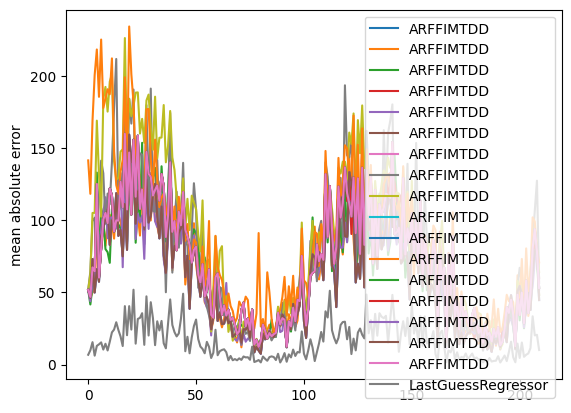

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from delayed_evaluation import delayed_prequential_evaluation

# Run all tests

results = []

for learner in models:
    print(f"Running {learner}")
    result = delayed_prequential_evaluation(stream=stream, learner=learner, window_size=5000)
    print(f"Done in {result['cpu_time']} secs")
    sns.lineplot(result['windowed'].metrics_per_window()["mean absolute error"], label=learner.__str__())
    results.append(result)

plt.show()


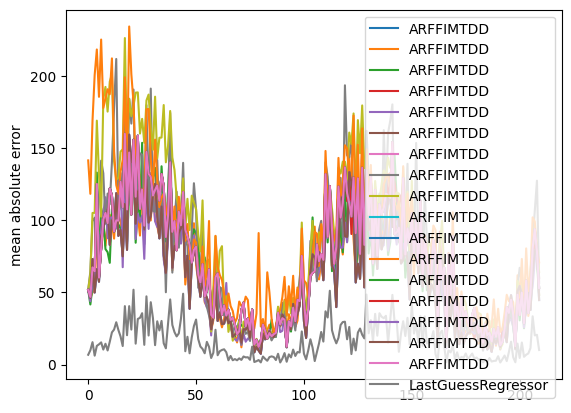

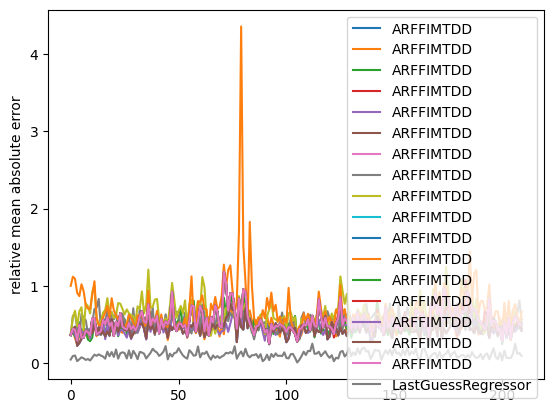

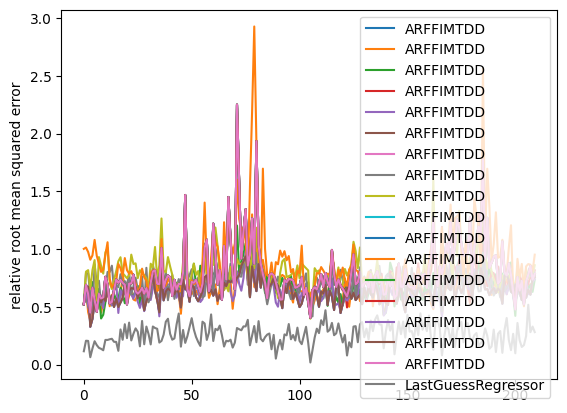

TypeError: 'NoneType' object is not subscriptable

In [18]:
for learner, result in zip(models, results):
    if learner.__str__() != "GaussianRandomRegressor":
        sns.lineplot(result['windowed'].metrics_per_window()["mean absolute error"], label=learner.__str__())
plt.show()

for learner, result in zip(models, results):
    if learner.__str__() != "GaussianRandomRegressor":
        sns.lineplot(result['windowed'].metrics_per_window()["relative mean absolute error"], label=learner.__str__())
plt.show()

for learner, result in zip(models, results):
    if learner.__str__() != "GaussianRandomRegressor":
        sns.lineplot(result['windowed'].metrics_per_window()["relative root mean squared error"], label=learner.__str__())

plt.show()

for learner, result in zip(models, results):
    if learner.__str__() != "GaussianRandomRegressor":
        plt.plot(range(0,10000),  result['predictions'][:10000], label=learner.__str__())

plt.plot(range(0,10000), results[0]['ground_truth_y'][:10000], label="ground_truth_y")

In [21]:
#reg = regressors.RandomRegressor(schema=stream.get_schema())
from capymoa.regressor import SOKNLBT, SGDRegressor, PassiveAggressiveRegressor, ORTO, ARFFIMTDD, AdaptiveRandomForestRegressor, FIMTDD
from delayed_evaluation import delayed_prequential_evaluation

reg = ARFFIMTDD(schema,alternate_tree_t_min=1000,page_hinckley_alpha=0.9,page_hinckley_threshold=1000, alternate_tree_fading_factor=0.9999999,learning_ratio=0.0001,learning_ratio_decay_factor=0.00001)
#reg = regressors.LastGuessRegressor(schema=stream.get_schema())
res = delayed_prequential_evaluation(stream=stream, learner=reg, window_size=5000, store_predictions=True,store_y=True,delay=1440)
print(res['cpu_time'])

38.66899560000002


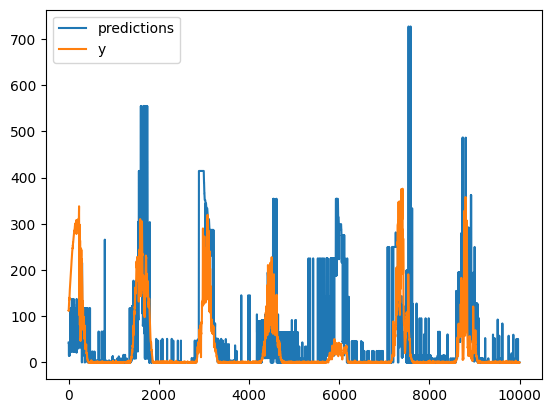

In [23]:
#sns.lineplot(res['predictions'], label="predictions")
#sns.lineplot(result['ground_truth_y'], label="y")
import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(range(0,10000),  res['predictions'][900000:910000], label="predictions")

plt.plot(range(0,10000), res['ground_truth_y'][900000:910000], label="y")

# show label
plt.legend()

#res.keys()

<Axes: ylabel='mean absolute error'>

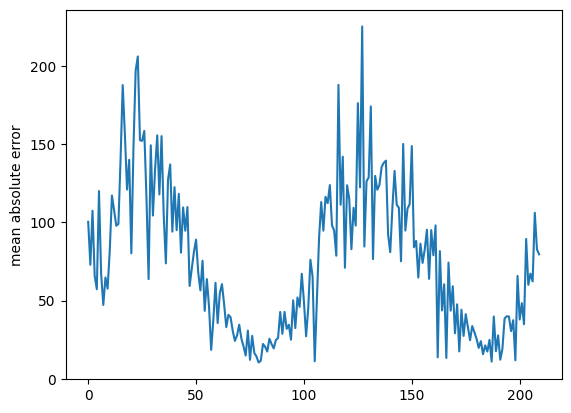

In [9]:

sns.lineplot(res['windowed'].metrics_per_window()["mean absolute error"])